In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sys
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.fft import fft, fftfreq
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'
sns.set_palette("husl")

# Data Simulation

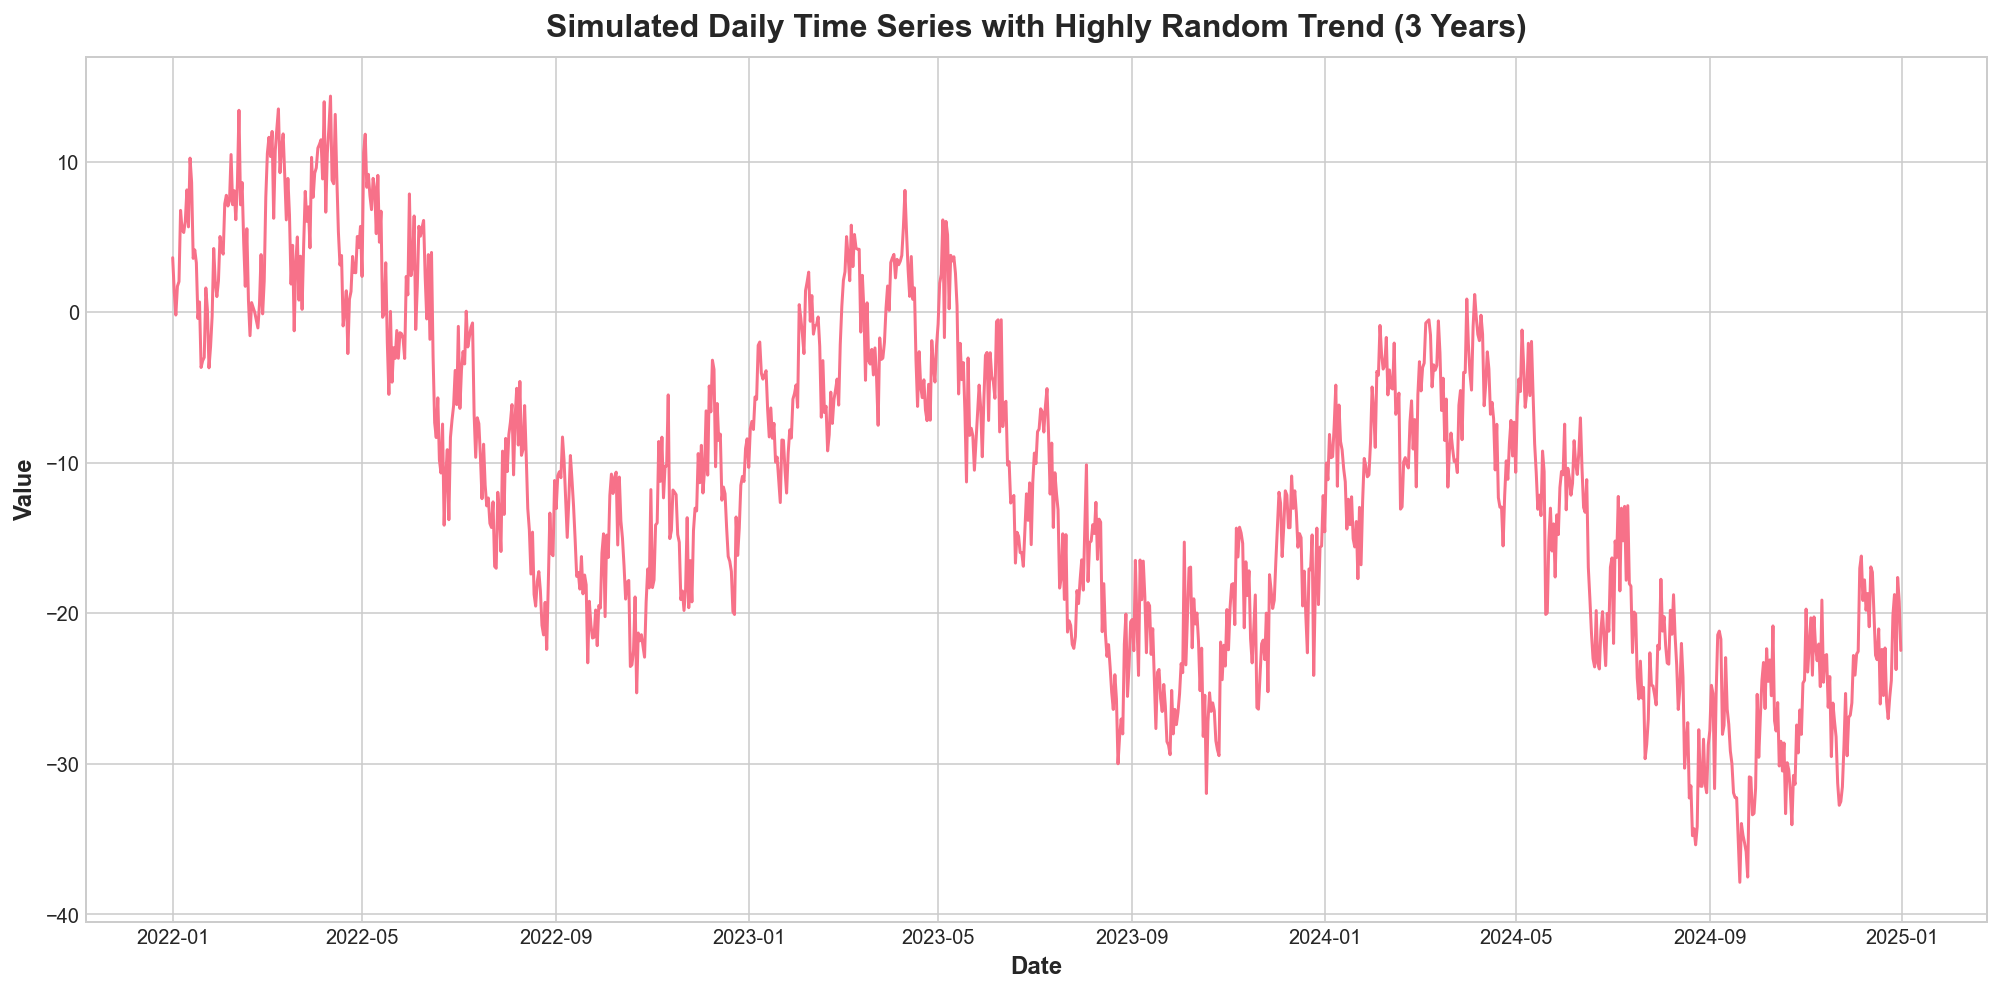

In [2]:
dates = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D')

# Random walk without drift
trend_steps = np.random.normal(loc=[0], scale=0.2, size=len(dates))
trend = np.cumsum(trend_steps)

yearly_seasonality = 10 * np.sin(2 * np.pi * dates.dayofyear / 365)
monthly_seasonality = 5 * np.sin(2 * np.pi * dates.day / 30)
noise = np.random.normal(loc=0, scale=2, size=len(dates))

data = trend + yearly_seasonality + monthly_seasonality + noise

time_series = pd.DataFrame(data, index=dates)
time_series = time_series.reset_index()
time_series.columns = ['date', 'values']

plt.figure(figsize=(14, 7))
plt.plot(time_series.set_index('date')['values'])
plt.title('Simulated Daily Time Series with Highly Random Trend (3 Years)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# Time Series Forcastor

In [3]:
notebook_dir = os.getcwd() 
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Added '{project_root}' to the Python path")
    
from time_series_data_nature_discovery import TimeSeriesAnalyzer

Added '/Users/dctmh/Python Code/stat_test' to the Python path


In [4]:
class TimeSeriesForcastor(TimeSeriesAnalyzer):
    def __init__(self, data, date_column, value_column):
        super().__init__(data, date_column, value_column)
        self.train_ts, self.val_ts, self.test_ts = self.__class__.split_time_series(self.ts)
        # perform all the baseline model
        self.naive_pred, self.naive_rmse = self.__class__.naive_forecast(self.train_ts, self.test_ts)
        self.aver_pred, self.aver_rmse = self.__class__.average_forecast(self.train_ts, self.test_ts)
        self.sim_drift_pred, self.sim_drift_rmse = self.__class__.simple_drift_forecast(self.train_ts, self.test_ts)
        self.seasonal_week_pred, self.seasonal_week_rmse = self.__class__.seasonal_naive_forecast(self.train_ts, self.test_ts)
        self.recent_drift_pred, self.recent_drift_rmse = self.__class__.recent_drift_forecast(self.train_ts,self.test_ts)
    
    def time_step_lag_linear_regression_plot(self):
        fig, axes = plt.subplots(2, 1, figsize=(15, 10))
        axes[0].plot(self.df['time'], self.df[self.value_column], color='0.75')
        sns.regplot(x='time', y=self.value_column, data=self.df,
                    ci=None, scatter_kws=dict(color='0.25'), ax=axes[0])
        axes[0].set_title(f'Time Plot of {self.value_column}')

        sns.regplot(x='lag_1', y=self.value_column, data=self.df,
                    ci=None, scatter_kws=dict(color='0.25'), ax=axes[1])
        axes[1].set_aspect('equal')
        axes[1].set_title(f'Lag Plot (Shift = 1) of {self.value_column}')

    def time_step_linear_regression_fit(self):
        X = self.df.loc[:, ['time']]
        y = self.df.loc[:, self.value_column]

        model = LinearRegression()
        model.fit(X, y)
        y_pred = pd.Series(model.predict(X), index=X.index)
        # plot the model got fitted
        ax = y.plot(**plot_params)
        ax = y_pred.plot(ax=ax, linewidth=3)
        ax.set_title(f'Time Plot of {self.value_column}')
        # Access the coefficients and intercept
        print(f"Intercept: {model.intercept_}")
        print(f"Coefficients: {model.coef_}")
        return model, y, y_pred

    def lag_linear_regression_fit(self):
        X = self.df.loc[:, ['lag_1']].dropna()
        y = self.df.loc[:, self.value_column]
        # drop the target value that's from the blank
        y, X = y.align(X, join='inner')

        model = LinearRegression()
        model.fit(X, y)
        y_pred = pd.Series(model.predict(X), index=X.index)
        # plot the model got fitted
        fig, ax = plt.subplots()
        ax.plot(X['lag_1'], y, '.', color='0.25')
        ax.plot(X['lag_1'], y_pred)
        ax.set(aspect='equal', ylabel=f'{self.value_column}',
               xlabel='lag_1', title=f'Lag Plot of {self.value_column}')
        # Access the coefficients and intercept
        print(f"Intercept: {model.intercept_}")
        print(f"Coefficients: {model.coef_}")
        return model, y, y_pred
    
    def plot_pred_basic(self, method="naive"):
        
        if method.lower()=='naive':
            pred_index = self.naive_pred.index
            pred_values = self.naive_pred.values
            title = f'Naive Forecast vs. Actual Data (RMSE: {self.naive_rmse:.2f})'
        elif method.lower() == 'average':
            pred_index = self.aver_pred.index
            pred_values = self.aver_pred.values
            title = f'Average Forecast vs. Actual Data (RMSE: {self.aver_rmse:.2f})'
        elif method.lower() == 'sim_drift':
            pred_index = self.sim_drift_pred.index
            pred_values = self.sim_drift_pred.values
            title = f'Simple drift Forecast vs. Actual Data (RMSE: {self.sim_drift_rmse:.2f})'
        elif method.lower() =='season_naive':
            pred_index = self.seasonal_week_pred.index
            pred_values = self.seasonal_week_pred.values
            title = f'Seasonal drift (7days) Forecast vs. Actual Data (RMSE: {self.seasonal_week_rmse:.2f})'
        elif method.lower() =='recent_drift':
            pred_index = self.recent_drift_pred.index
            pred_values = self.recent_drift_pred.values
            title = f'Recent drift (7days) Forecast vs. Actual Data (RMSE: {self.recent_drift_rmse:.2f})'
        
        plt.figure(figsize=(10,6))
        # plot the original data in different colors
        # train data
        plt.plot(self.train_ts.index, 
                 self.train_ts.values, 
                 color = 'blue',
                 label = "Training Data"
                )
        # validation data
        plt.plot(self.val_ts.index, 
         self.val_ts.values, 
         color = 'orange',
         label = "Validation Data"
        )
        # test data
        plt.plot(self.test_ts.index, 
         self.test_ts.values, 
         color = 'green',
         label = "Test Data"
        )
        # pred data
        plt.plot(pred_index,
                 pred_values,
                 color = 'red',
                 label = 'Prediction'
        )
        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel(self.value_column)
        plt.grid(True)
        plt.show()
        
    def find_d_parameter(self, max_d = 3):
        """
        
        """
        print("\n--- Finding Optimal 'd' Parameter ---")
        d = 0
        current_series = self.train_ts.dropna()

        for _ in range(max_d + 1):
            # Run the ADF test on the current series
            adf_result = adfuller(current_series)
            p_value = adf_result[1]
            
            print(f"Testing with d = {d}...")
            print(f"  ADF p-value: {p_value:.4f}")
            
            # Check if the series is stationary
            if p_value <= 0.05:
                print(f"  Result: Series is stationary. Optimal d = {d}")
                return d, current_series
            
            # If not stationary and we haven't reached max_d, difference the series
            if d < max_d:
                print("  Result: Series is non-stationary. Differencing...")
                d += 1
                current_series = current_series.diff().dropna()
            else:
                print(f"  Result: Could not achieve stationarity after {max_d} differencing steps.")
                return None, None # Or handle as an error
            
        return d, current_series    
    
    @staticmethod
    def naive_forecast(train, test):
        "Forecasts the next value as the last observed value."
        # The last value of the training set is the first prediction
        last_value = train.iloc[-1]

        # All predictions for the test set are this same last value
        predictions = pd.Series(last_value, index=test.index)

        # Calculate error
        rmse = np.sqrt(mean_squared_error(test, predictions))
        return predictions, rmse


    @staticmethod
    def average_forecast(train, test):
        "Forecast all the future value as the mean of training data"
        # calculate the mean from all the train values
        mean_values = train.mean()
        
        # assign the mean value for all the predictions
        predictions = pd.Series(mean_values, index = test.index)
        
        # compare both the prediction value & the true value
        rmse = np.sqrt(mean_squared_error(test, predictions))
        return predictions,rmse

    @staticmethod
    def simple_drift_forecast(train, test):
        "Forecase using the last value with a simple trend component (slope calculated from the last & first value)"
        if len(train) <2:
            drift = 0
            print("Not enough train data for calculating the drift")
        else:
            slope = (train.iloc[-1] - train.iloc[0]) / (len(train) - 1)

        h = np.arange(1, len(test) + 1)

        last_value = train.iloc[-1]

        predictions = last_value + h * slope
        predictions = pd.Series(predictions, index = test.index)

        rmse = np.sqrt(mean_squared_error(test, predictions))

        return predictions, rmse

    @staticmethod
    def seasonal_naive_forecast(train, test, seasonal_period=7):
        last_season = train.iloc[-seasonal_period:]

        num_repeats = int(np.ceil(len(test) / seasonal_period))
        repeated_season = np.tile(last_season, num_repeats)

        predictions = pd.Series(repeated_season[:len(test)], index = test.index)

        rmse = np.sqrt(mean_squared_error(test, predictions))
        return predictions, rmse

    @staticmethod
    def recent_drift_forecast(train, test, window = 30):
        if len(train) < window:
            raise ValueError("Window size cannot be larger than the training data length.")

        recent_data = train.iloc[-window:]

        if len(recent_data) < 2:
            slope = 0
        else:
            slope = (recent_data.iloc[-1] - recent_data.iloc[0]) / (len(recent_data) - 1)

        h = np.arange(1, len(test) + 1)

        last_value = train.iloc[-1]
        predictions = last_value + h * slope
        predictions = pd.Series(predictions, index = test.index)

        rmse = np.sqrt(mean_squared_error(test, predictions))

        return predictions, rmse
    
    @staticmethod
    def fourier_features_forecast(X, y, dp, future_steps=90):
        """
        """
        model = LinearRegression(fit_intercept = False)

        _ = model.fit(X,y)
        y_pred = pd.Series(model.predict(X), index=y.index)
        X_fore = dp.out_of_sample(steps=future_steps)
        y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)
        ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
        ax = y_pred.plot(ax=ax, label="Seasonal")
        ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
        _ = ax.legend()
        return y_pred, X_fore, y_fore
    
    @staticmethod
    def split_time_series(ts, train_pct=0.7, val_pct=0.15, test_pct=0.15):
        """
        Splits a time series chronologically into training, validation, and test sets.

        Args:
            ts (pd.Series): The time series data with a DatetimeIndex.
            train_pct (float): Percentage of data for the training set.
            val_pct (float): Percentage of data for the validation set.
            test_pct (float): Percentage of data for the test set.

        Returns:
            tuple: A tuple containing (train, val, test) pandas Series.
        """
        if round(train_pct + val_pct + test_pct, 10) != 1.0:
            raise ValueError("Percentages must sum to 1.0")

        n = len(ts)

        # Calculate split points
        train_end_idx = int(n * train_pct)
        val_end_idx = int(n * (train_pct + val_pct))

        # Split the data
        train_data = ts.iloc[:train_end_idx]
        val_data = ts.iloc[train_end_idx:val_end_idx]
        test_data = ts.iloc[val_end_idx:]

        print("--- Time Series Split ---")
        print(f"Training Set:   {len(train_data)} points ({train_data.index.min().date()} to {train_data.index.max().date()})")
        print(f"Validation Set: {len(val_data)} points ({val_data.index.min().date()} to {val_data.index.max().date()})")
        print(f"Test Set:       {len(test_data)} points ({test_data.index.min().date()} to {test_data.index.max().date()})")
        
        return train_data, val_data, test_data

In [5]:
time_series_forecastor = TimeSeriesForcastor(time_series, date_column = 'date', value_column = 'values')

--- Time Series Split ---
Training Set:   767 points (2022-01-01 to 2024-02-06)
Validation Set: 164 points (2024-02-07 to 2024-07-19)
Test Set:       165 points (2024-07-20 to 2024-12-31)


## Baseline model for Benchmark

Models used for a benchmark to compare with complicated models and see if they perform better than the benchmark or not.

### Naive forecasting model

Every forecast value is set to the last observed value from the data. While useful as a benchmark, this method is not expected to be accurate at all.

In [6]:
# data got assigned with last day value
(time_series_forecastor.naive_pred == time_series_forecastor.train_ts.iloc[-1]).all()

True

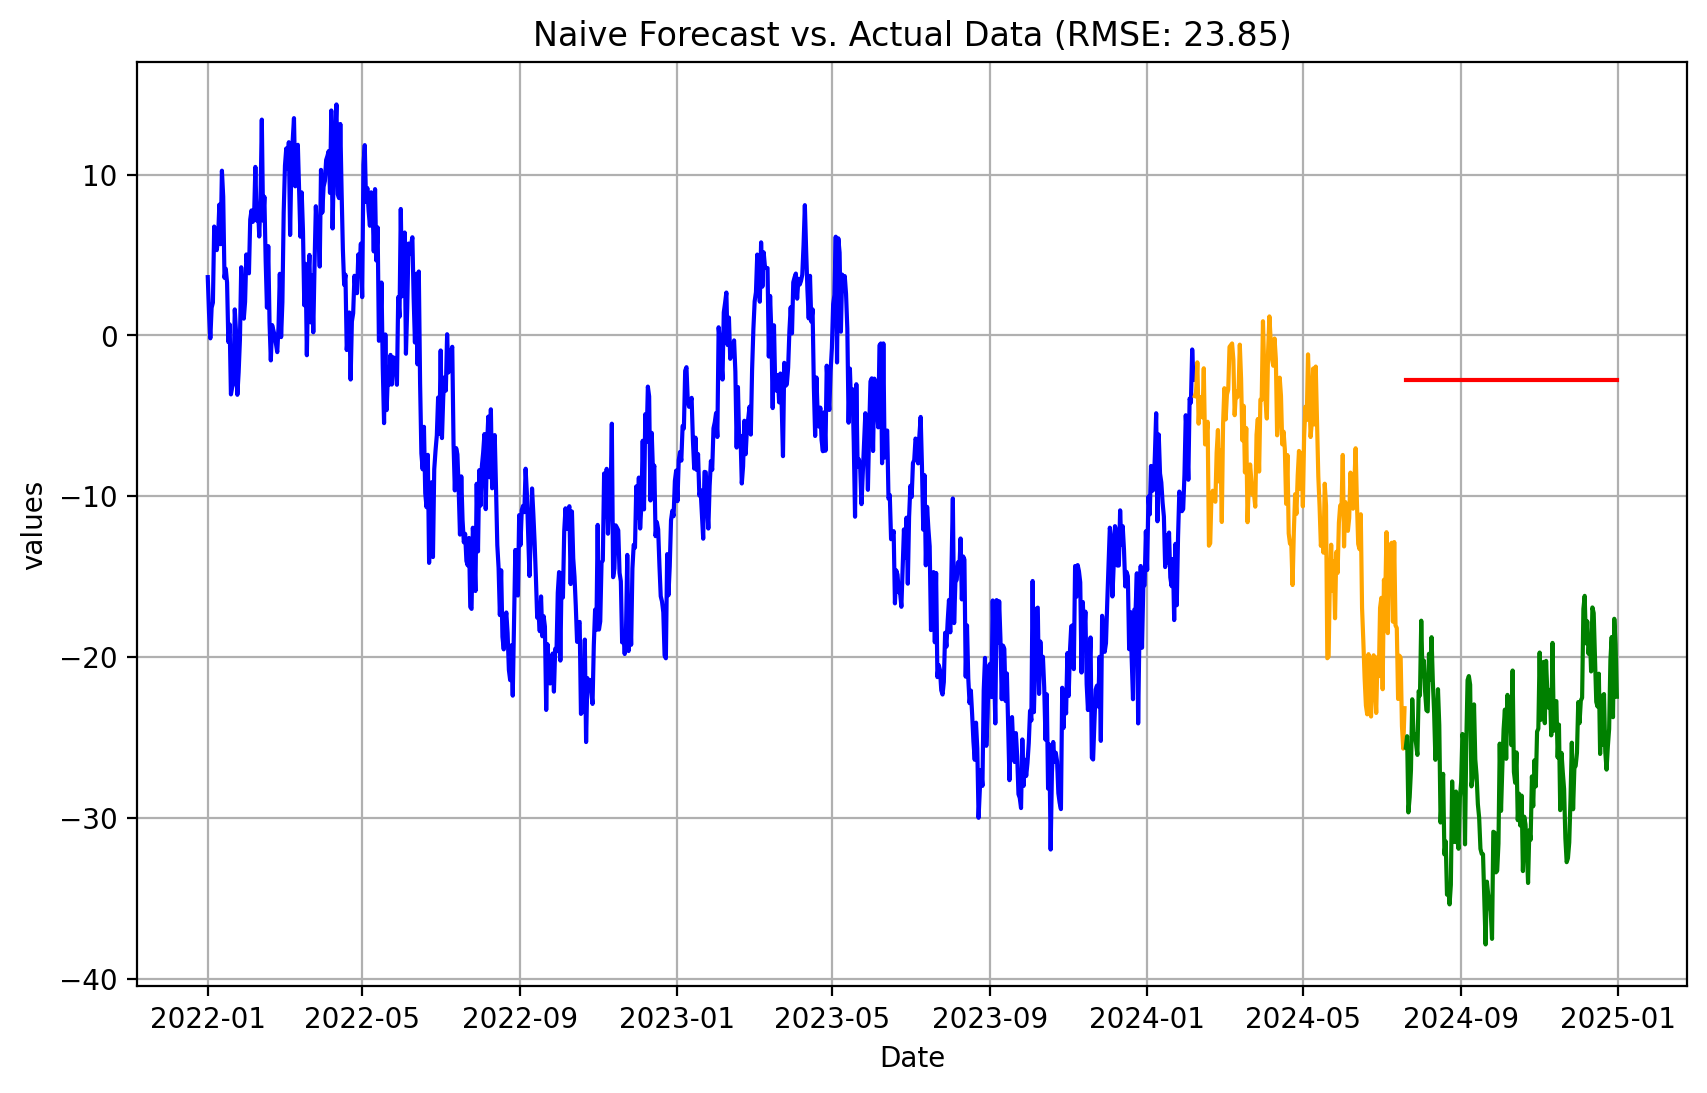

In [7]:
# plot the train, test and pred
time_series_forecastor.plot_pred_basic()

In [8]:
# show the mean square error to check the accuracy
time_series_forecastor.naive_rmse

23.84810396608228

### Average forecasting model

All forecast values are set to the average of the training data. This method serves as a benchmark and is expected to perform better than a naive forecasting model.

In [9]:
# data got assigned with average value of the train dataset
(time_series_forecastor.aver_pred == time_series_forecastor.train_ts.mean()).all()

True

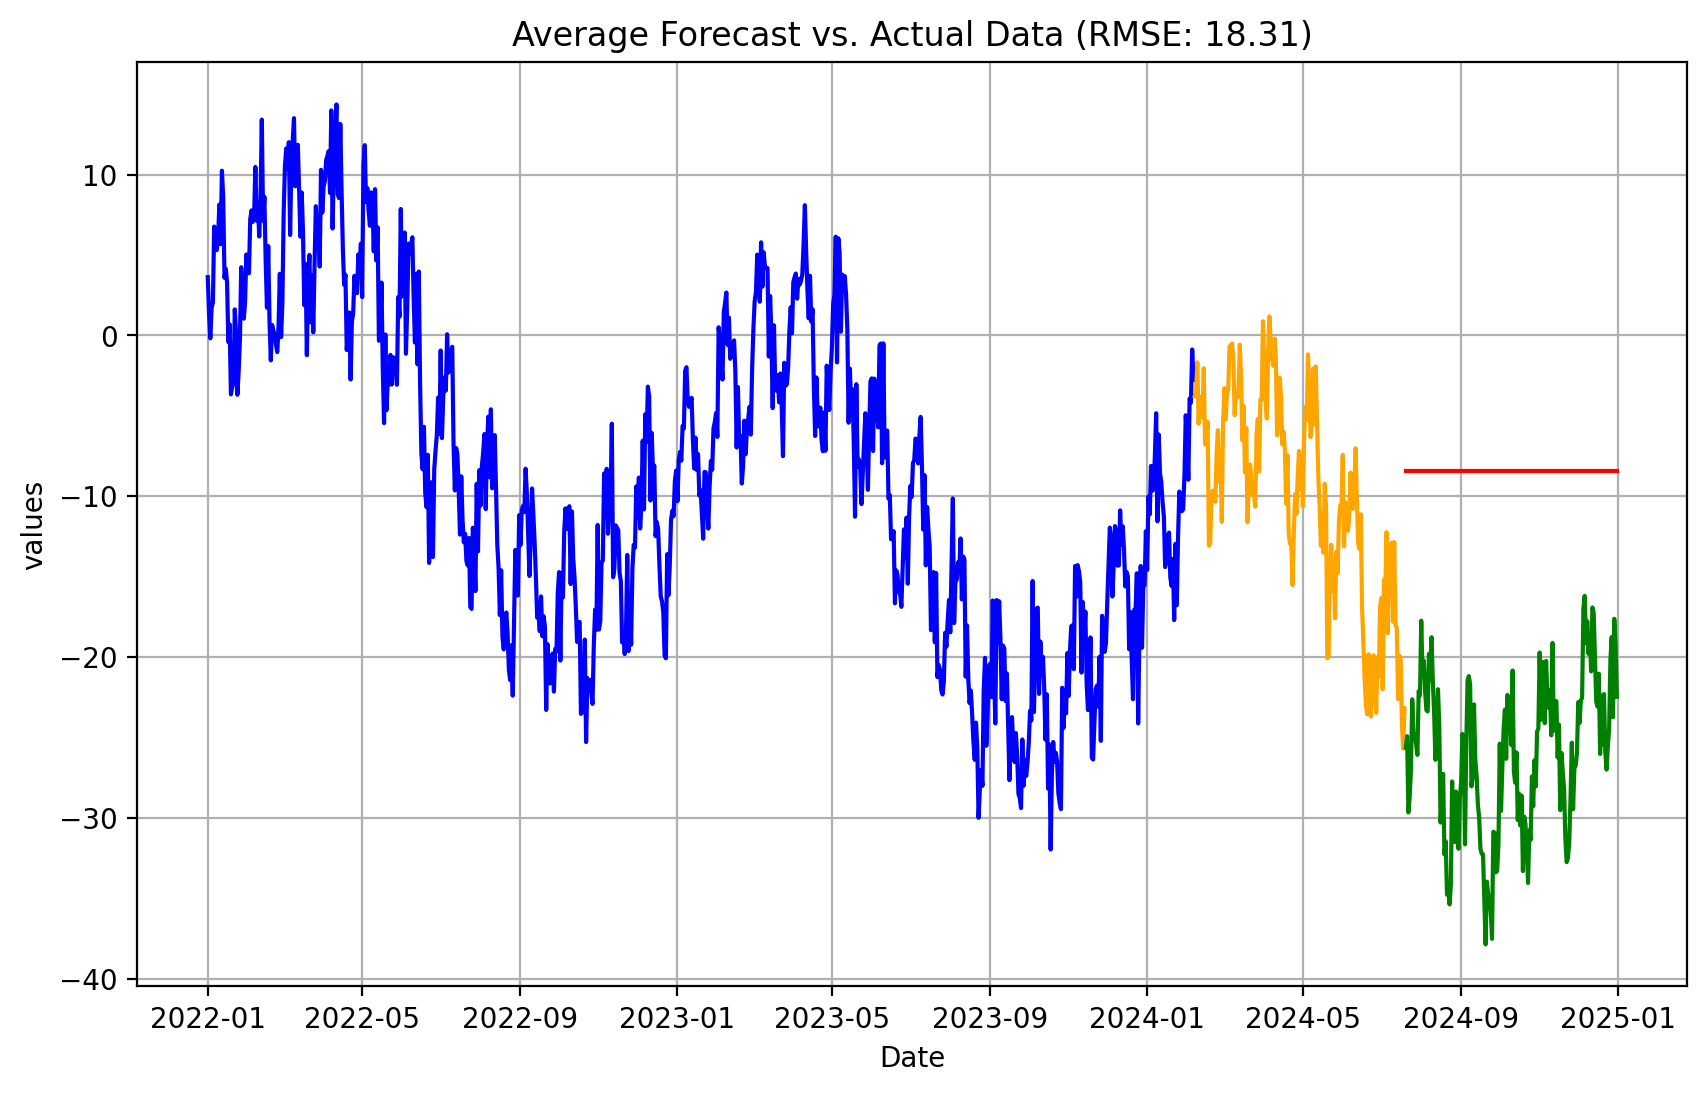

In [10]:
# plot the train, test and pred
time_series_forecastor.plot_pred_basic(method='average')

In [11]:
# show the mean square error to check the accuracy
time_series_forecastor.aver_rmse

18.31070635236767

### Simple Drift Forecasting Model

To generate a prediction, the slope is first calculated from the first and last values, and then used to extrapolate from the final value for a length matching the test data.

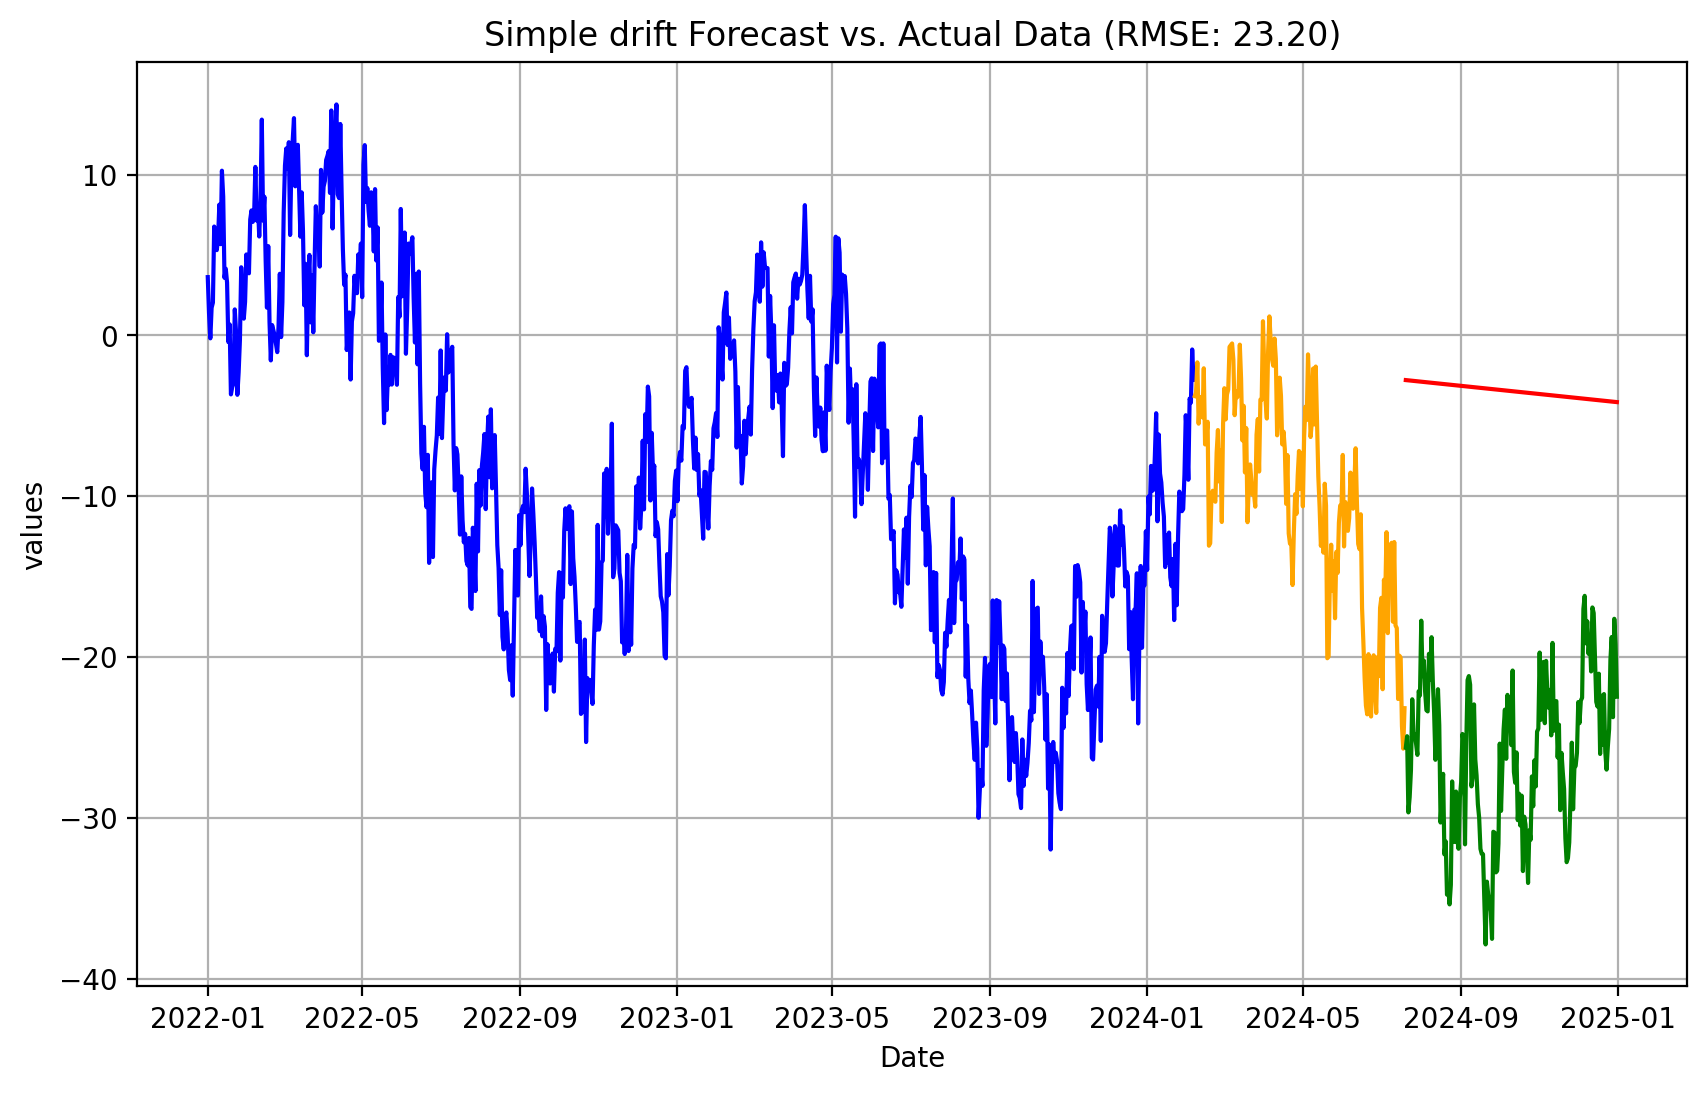

In [12]:
# plot the train, test and pred
time_series_forecastor.plot_pred_basic(method='sim_drift')

In [13]:
# show the mean square error to check the accuracy
time_series_forecastor.sim_drift_rmse

23.195400074281974

### Seasonal Naive Forecasting Model (Default = last 7 days)

This method creates a forecast by repeating the pattern of the last seasonal period. The length of the forecast is set to match the test data for comparison.

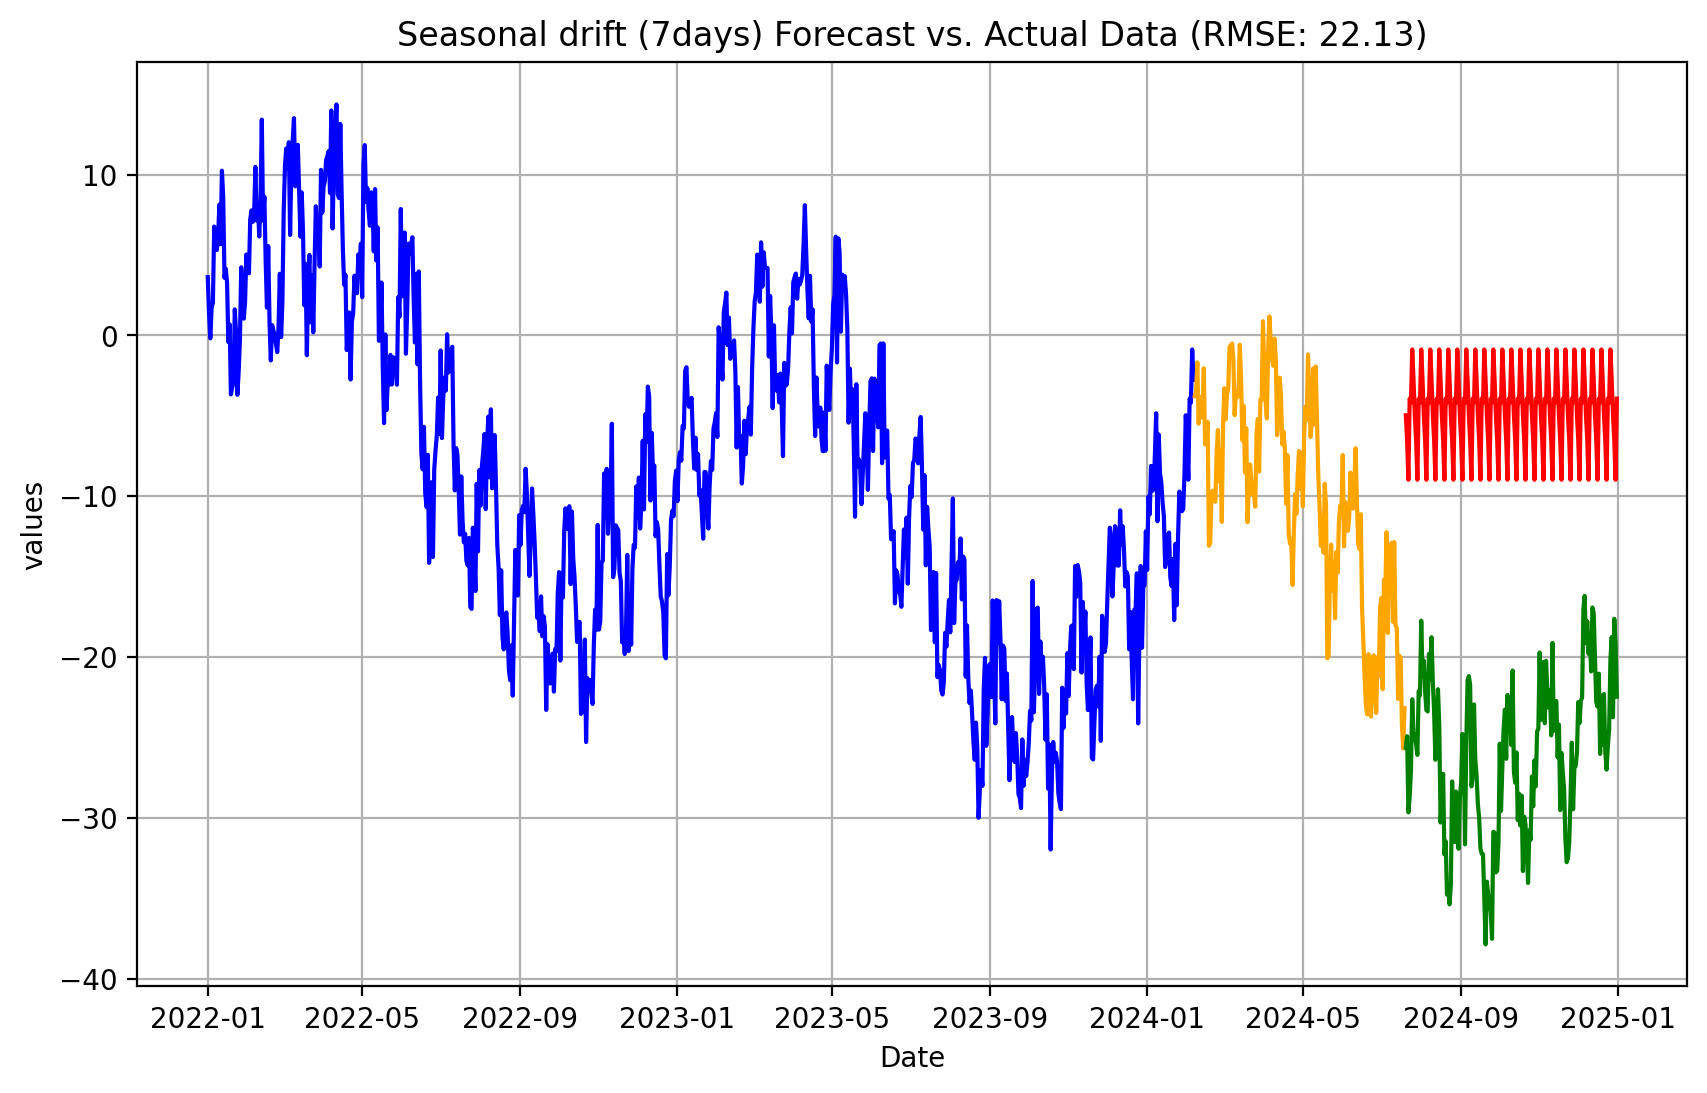

In [14]:
# plot the train, test and pred
time_series_forecastor.plot_pred_basic(method='season_naive')

In [15]:
# show the mean square error to check the accuracy
time_series_forecastor.seasonal_week_rmse

22.129821618612272

### Recent Drift Forecasting Model (Default = last 30 days)

A window of recent data is selected from the end of the training set. The slope of this window is then calculated to generate the prediction.

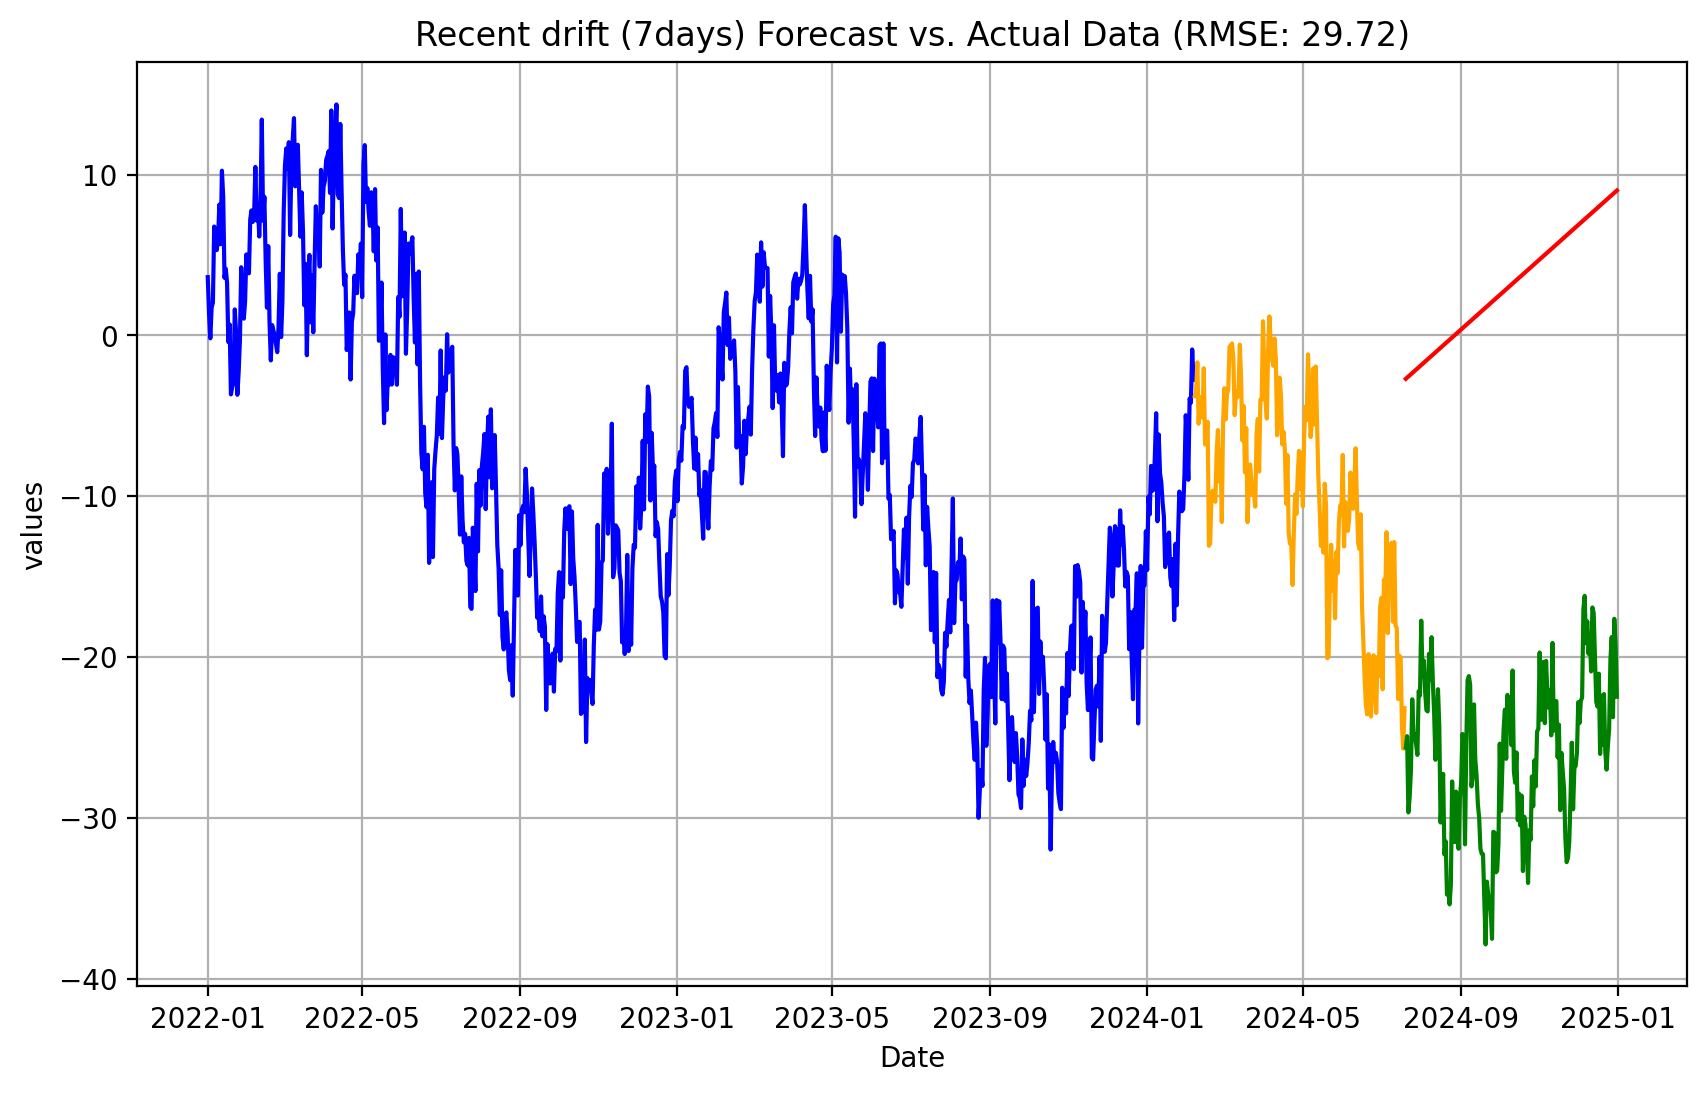

In [16]:
# plot the train, test and pred
time_series_forecastor.plot_pred_basic(method='recent_drift')

In [17]:
# show the mean square error to check the accuracy
time_series_forecastor.recent_drift_rmse

29.721147903394094

## Seasonality Forecasting model

### Fourier Pairs forecast

Try to get the pair needed by observing the periodogram.

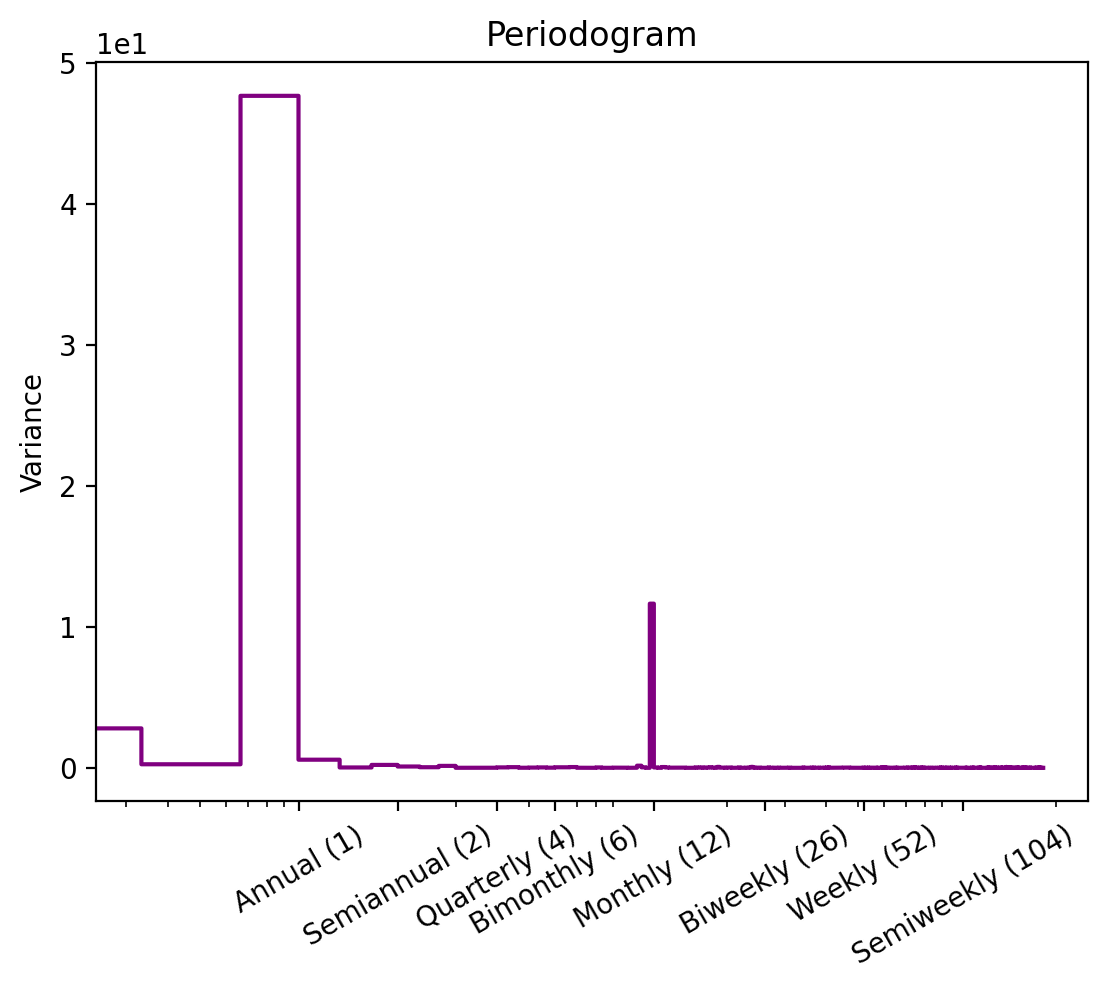

In [18]:
# get the peiordogram to check the pair needed
time_series_forecastor.plot_periodogram();

It's not obvious & may be trying with one pair first.

In [19]:
# TODO: Research the way to intepret the result from the periodogram

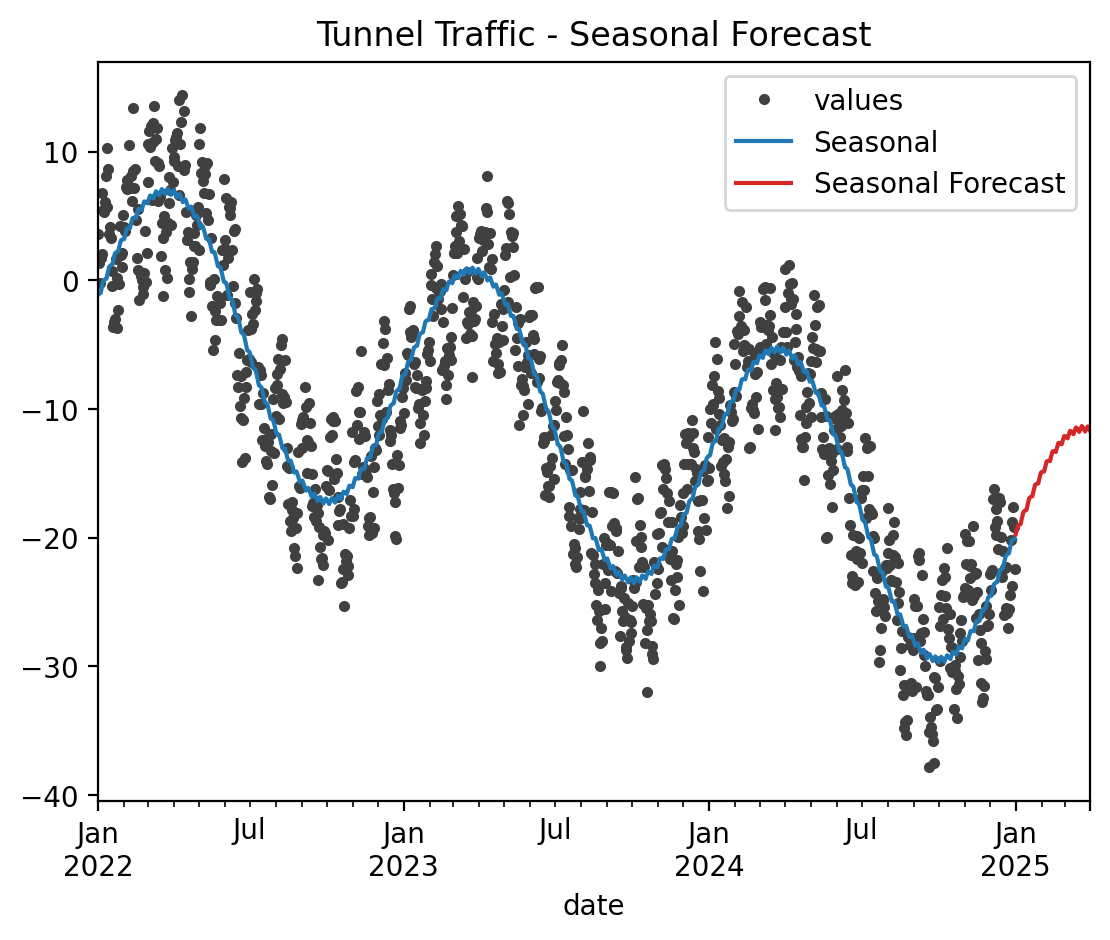

In [20]:
# get ready the training part with the fourier features & the deterministic process
X, dp = time_series_forecastor.fourier_features_capture(order = 1)
# get the target training data
y = time_series_forecastor.ts.asfreq('D')

# fit the feature and data into Linear regression and predict for future 90 days as default
y_pred, X_fore, y_fore = time_series_forecastor.fourier_features_forecast(X, y, dp)

## ARIMA Forecasting model

### ARIMA data simulator

We need a data simulator to generate data for testing our ARIMA-related functions and to ensure they work correctly.

In [21]:
# import the simulator
from arima_simulator import ARIMASimulator

In [22]:
# Instantiate the simulator
simulator = ARIMASimulator(n_samples=5000)

In [23]:
# Generate data for different situations
df_d0 = simulator.generate_arima_data(d=0, drift=0.2)
df_d1 = simulator.generate_arima_data(d=1, drift=0.2)
df_d2 = simulator.generate_arima_data(d=2, drift=0.2)

### Step 1: Ensure Stationarity

Fine the d value based on ADF Test. It works fine as we are able to see the d value for reference.

In [24]:
time_series_forecastor = TimeSeriesForcastor(df_d0, date_column = 'date', value_column = 'value')
d, ts = time_series_forecastor.find_d_parameter()

--- Time Series Split ---
Training Set:   3500 points (2020-01-01 to 2029-07-31)
Validation Set: 750 points (2029-08-01 to 2031-08-20)
Test Set:       750 points (2031-08-21 to 2033-09-08)

--- Finding Optimal 'd' Parameter ---
Testing with d = 0...
  ADF p-value: 0.0000
  Result: Series is stationary. Optimal d = 0


In [25]:
time_series_forecastor = TimeSeriesForcastor(df_d1, date_column = 'date', value_column = 'value')
d, ts = time_series_forecastor.find_d_parameter()

--- Time Series Split ---
Training Set:   3500 points (2020-01-01 to 2029-07-31)
Validation Set: 750 points (2029-08-01 to 2031-08-20)
Test Set:       750 points (2031-08-21 to 2033-09-08)

--- Finding Optimal 'd' Parameter ---
Testing with d = 0...
  ADF p-value: 0.9981
  Result: Series is non-stationary. Differencing...
Testing with d = 1...
  ADF p-value: 0.0000
  Result: Series is stationary. Optimal d = 1


In [26]:
time_series_forecastor = TimeSeriesForcastor(df_d2, date_column = 'date', value_column = 'value')
d, ts = time_series_forecastor.find_d_parameter()

--- Time Series Split ---
Training Set:   3500 points (2020-01-01 to 2029-07-31)
Validation Set: 750 points (2029-08-01 to 2031-08-20)
Test Set:       750 points (2031-08-21 to 2033-09-08)

--- Finding Optimal 'd' Parameter ---
Testing with d = 0...
  ADF p-value: 0.3105
  Result: Series is non-stationary. Differencing...
Testing with d = 1...
  ADF p-value: 0.4969
  Result: Series is non-stationary. Differencing...
Testing with d = 2...
  ADF p-value: 0.0000
  Result: Series is stationary. Optimal d = 2


### Step 2: Identify p and q

After ensure the data is stationary, we'll need to find the p (AR - AutoRegressive) and q value (MA - Moving Average).

- p: The relationship between an observation and a number of lagged observations (past values)
- q: The relationship between an observation and the residual errors from a moving average model applied to lagged observations

#### p value

In [27]:
# Generate data for p = 2 situation
df_p2 = simulator.generate_arima_data(d=0, p_coeffs=[0.7, -0.3])

In [28]:
time_series_forecastor = TimeSeriesForcastor(df_p2, date_column = 'date', value_column = 'value')

--- Time Series Split ---
Training Set:   3500 points (2020-01-01 to 2029-07-31)
Validation Set: 750 points (2029-08-01 to 2031-08-20)
Test Set:       750 points (2031-08-21 to 2033-09-08)


In [29]:
# make sure the time series become stationary
d, ts = time_series_forecastor.find_d_parameter()


--- Finding Optimal 'd' Parameter ---
Testing with d = 0...
  ADF p-value: 0.0000
  Result: Series is stationary. Optimal d = 0



=== AUTOCORRELATION ANALYSIS ===


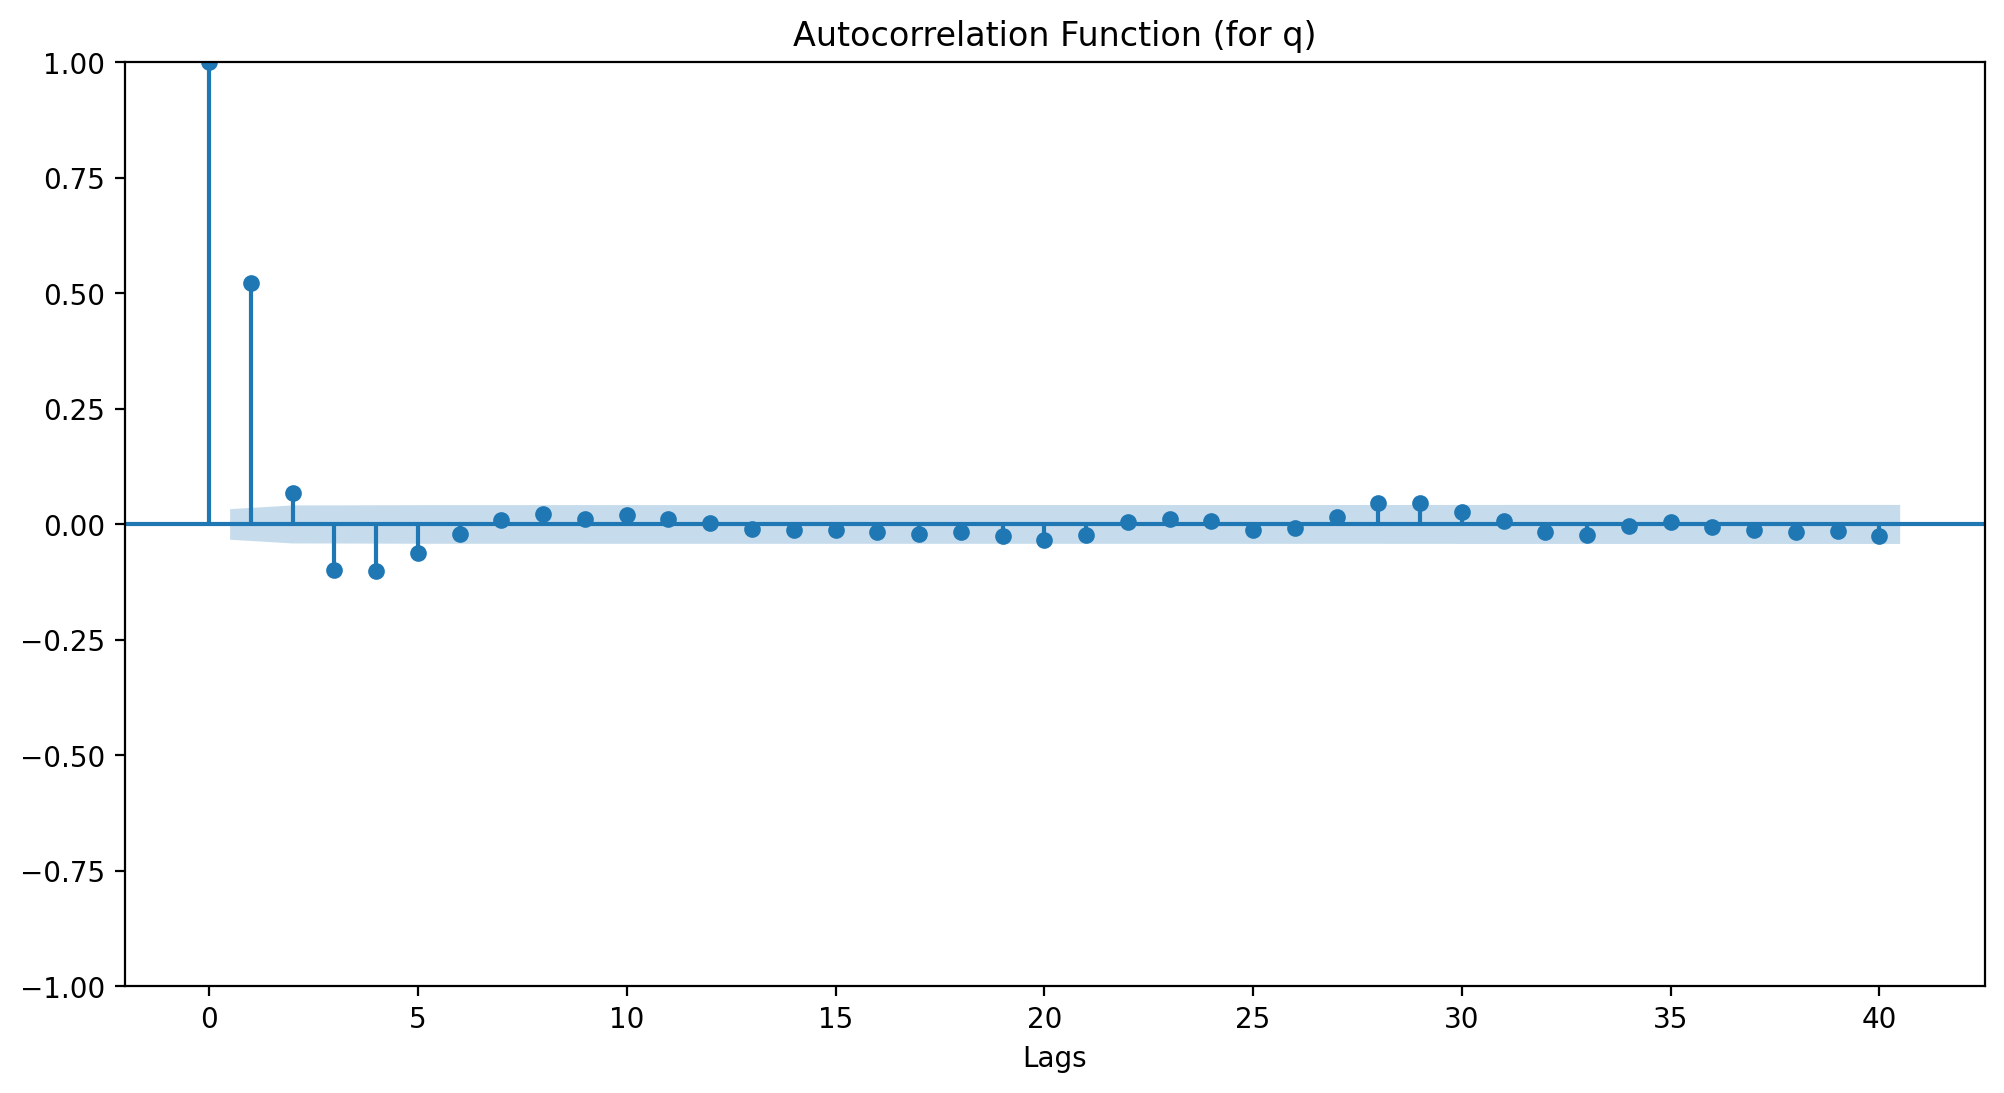

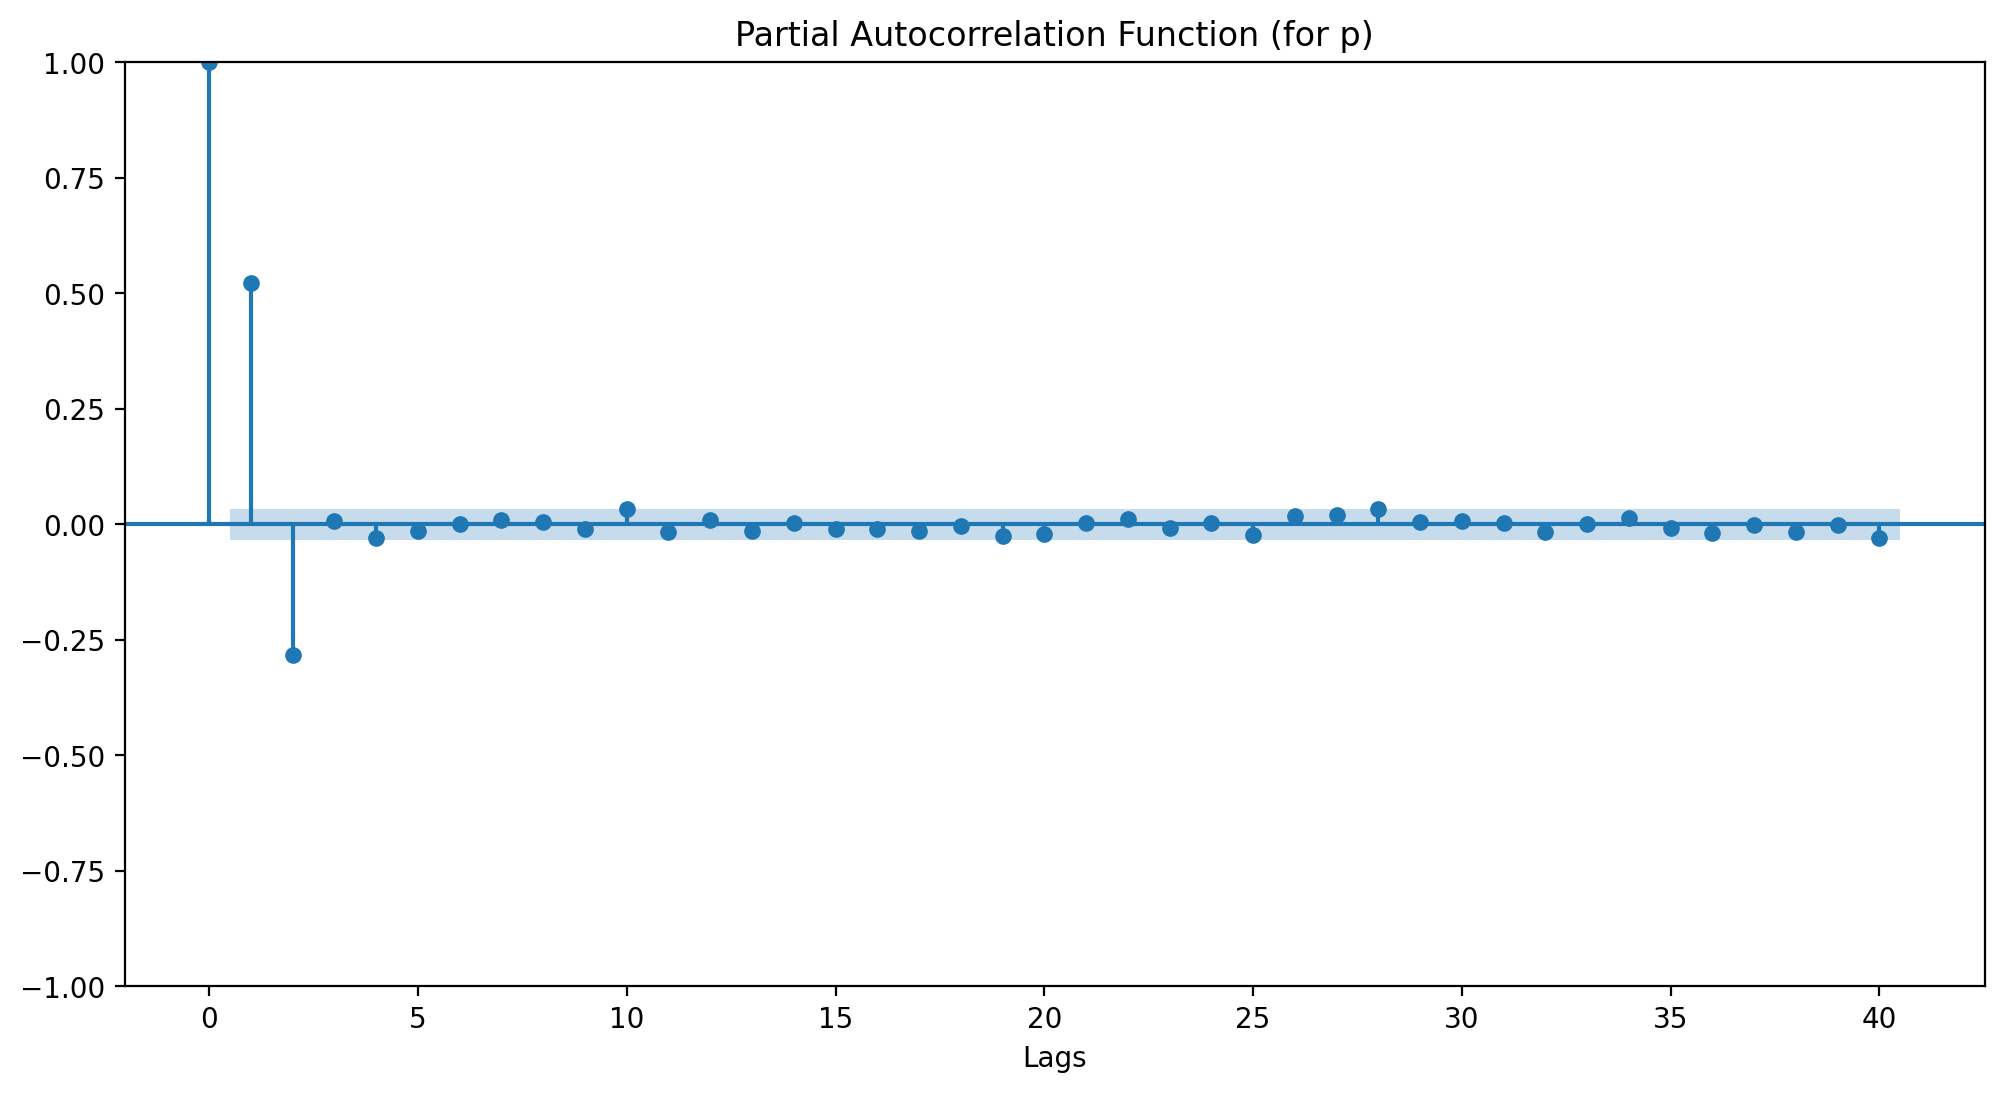


=== Overall correlation in daily ===
Lag 7 autocorrelation: 0.0084
Lag 30 autocorrelation: 0.0092
Lag 90 autocorrelation: -0.0151
Lag 180 autocorrelation: 0.0067
Lag 365 autocorrelation: -0.0202

--- Initial ARIMA Parameter Suggestion ---
The shaded area is the 95% confidence interval.
Spikes outside this area are statistically significant.

Suggested q value (from ACF cut-off): 5
Suggested p value (from PACF cut-off): 2

Note: These are starting points. Always test different parameter combinations.


In [30]:
q, p = time_series_forecastor.autocorrelation_analysis(diffed_ts=ts, find_pq=True)

#### q value

In [31]:
# Generate data for p = 1 situation
df_q1 = simulator.generate_arima_data(d=1,  q_coeffs=[0.8])

In [32]:
time_series_forecastor = TimeSeriesForcastor(df_q1, date_column = 'date', value_column = 'value')

--- Time Series Split ---
Training Set:   3500 points (2020-01-01 to 2029-07-31)
Validation Set: 750 points (2029-08-01 to 2031-08-20)
Test Set:       750 points (2031-08-21 to 2033-09-08)


In [33]:
# make sure the time series become stationary
d, ts = time_series_forecastor.find_d_parameter()


--- Finding Optimal 'd' Parameter ---
Testing with d = 0...
  ADF p-value: 0.6889
  Result: Series is non-stationary. Differencing...
Testing with d = 1...
  ADF p-value: 0.0000
  Result: Series is stationary. Optimal d = 1



=== AUTOCORRELATION ANALYSIS ===


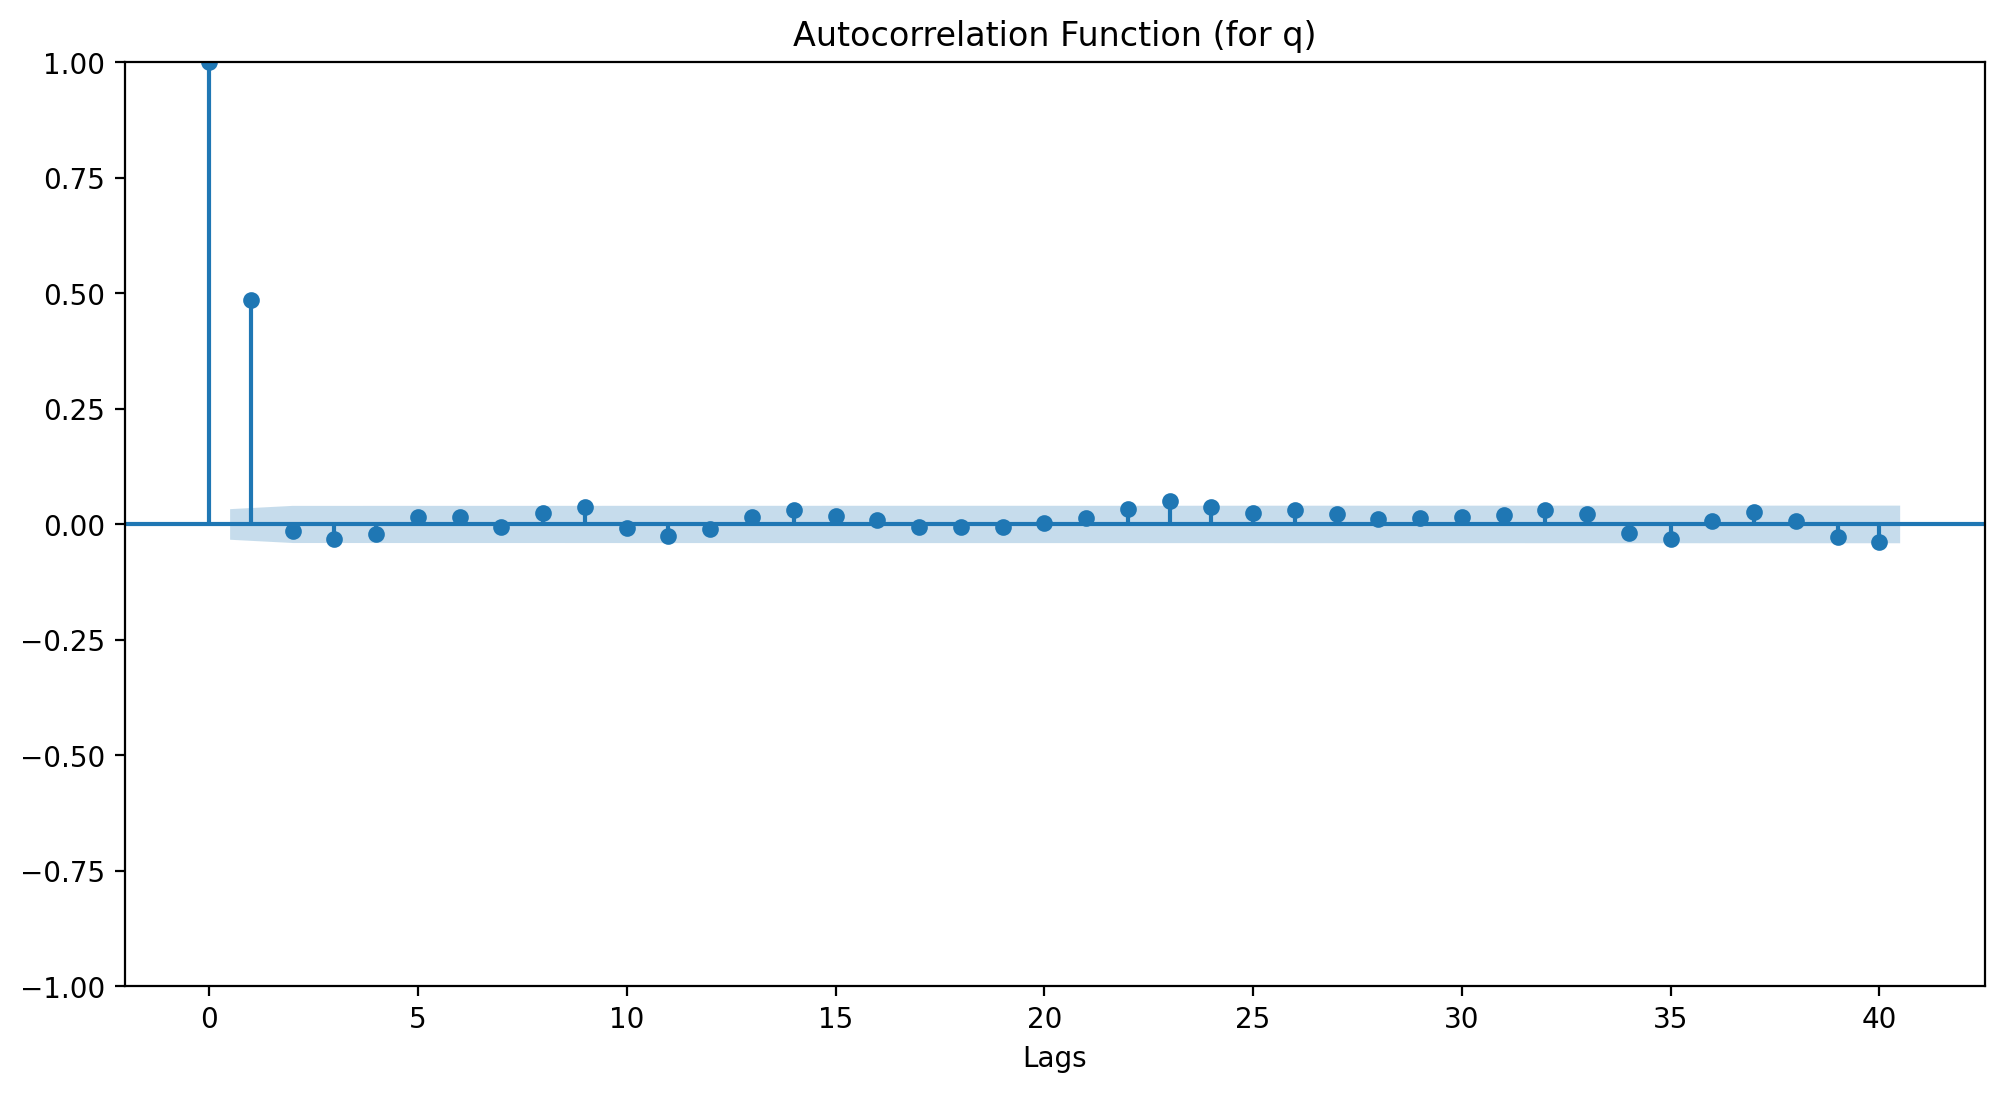

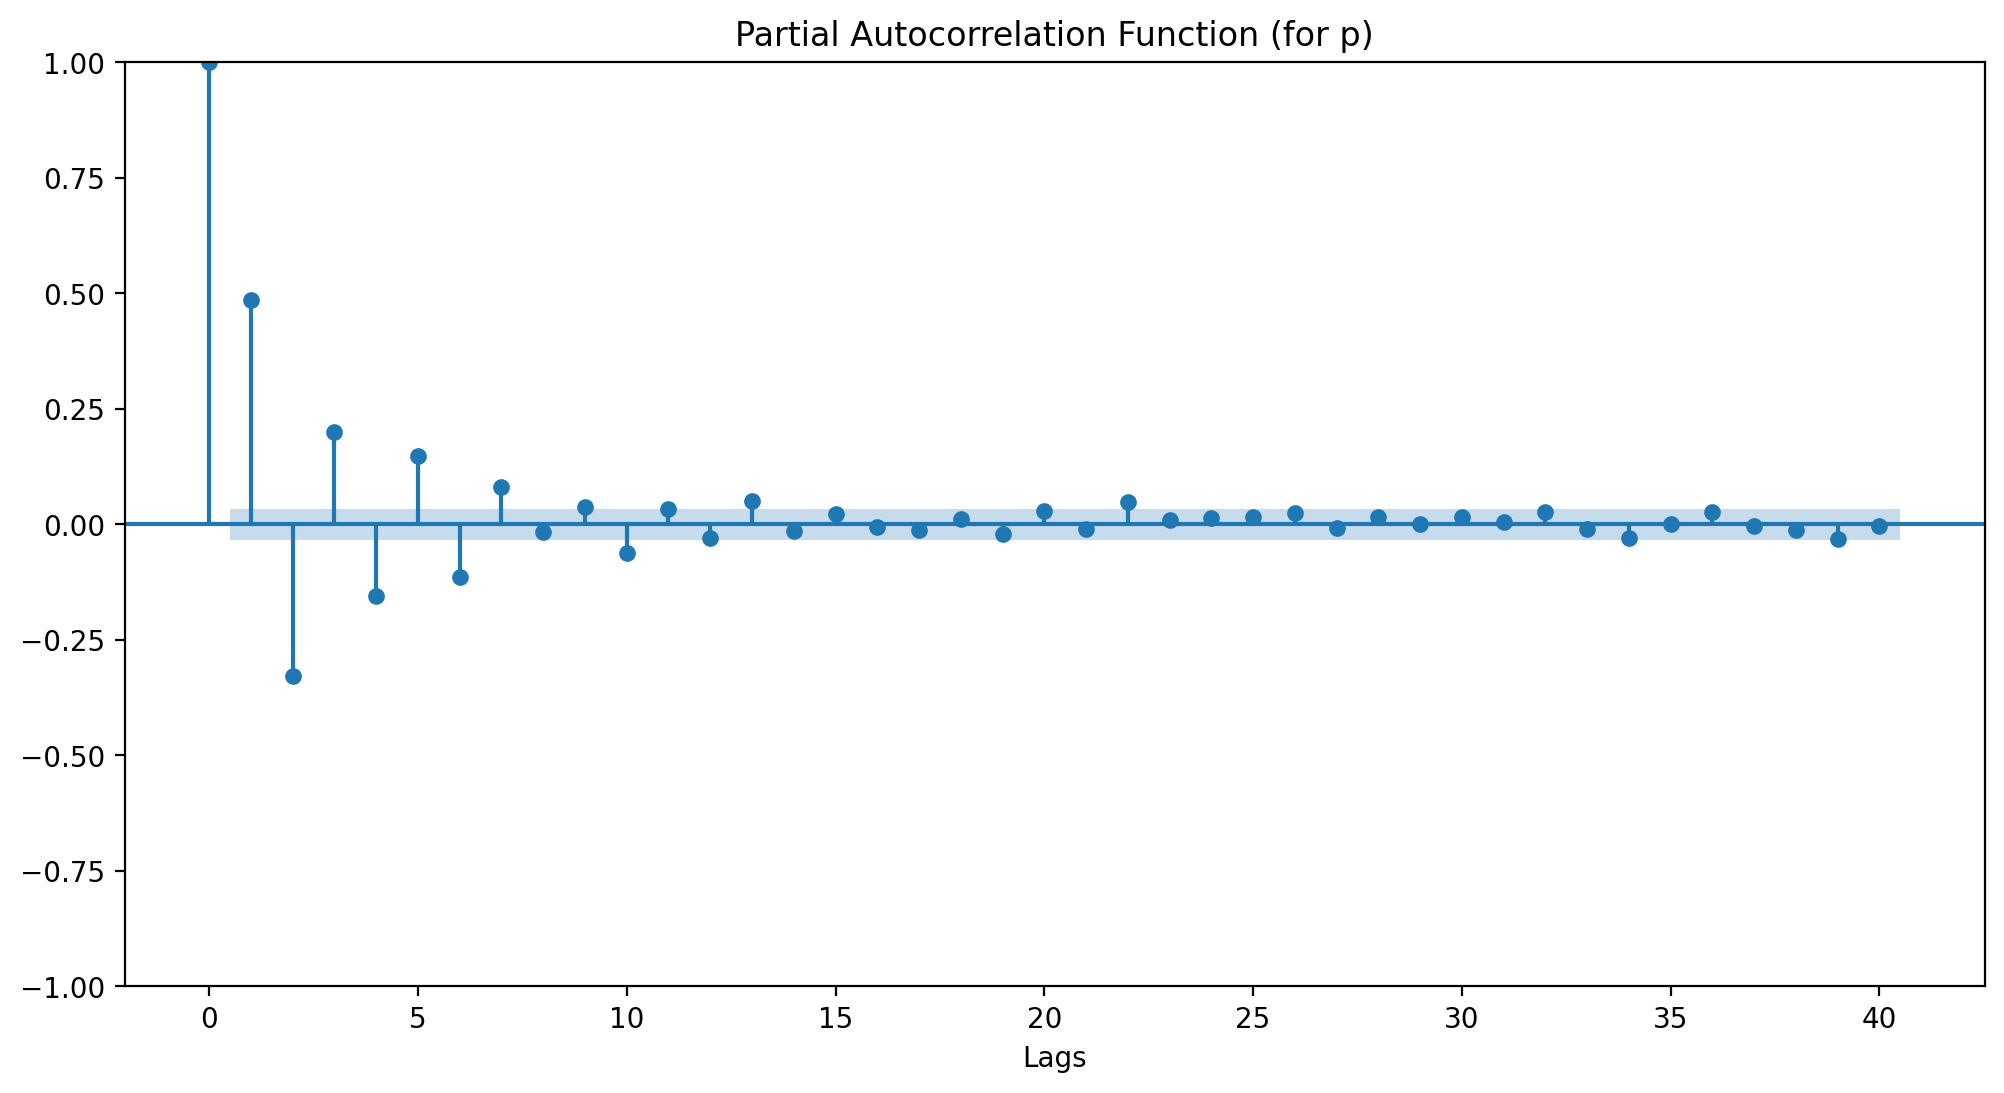


=== Overall correlation in daily ===
Lag 7 autocorrelation: 0.9963
Lag 30 autocorrelation: 0.9817
Lag 90 autocorrelation: 0.9432
Lag 180 autocorrelation: 0.8873
Lag 365 autocorrelation: 0.7662

--- Initial ARIMA Parameter Suggestion ---
The shaded area is the 95% confidence interval.
Spikes outside this area are statistically significant.

Suggested q value (from ACF cut-off): 1
Suggested p value (from PACF cut-off): 13

Note: These are starting points. Always test different parameter combinations.


In [34]:
q, p = time_series_forecastor.autocorrelation_analysis(diffed_ts=ts, find_pq=True)

In [35]:
# TODO: Time series feature Time Step & Lag_1